In [35]:
# 1. Imports
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

In [36]:
# 2. Helper Blocks (Downsample & Upsample)
# ===========================================================

def downsample(filters, size, apply_batchnorm=True):
    """
    Applies Conv2D → (optional) BatchNorm → LeakyReLU.
    Used to reduce spatial resolution ("encoder" part).
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    """
    Applies Conv2DTranspose → BatchNorm → (optional) Dropout → ReLU.
    Used to increase spatial resolution ("decoder" part).
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

In [37]:
# 3. Generator (U-Net style)
# ===========================================================

def build_generator():
    """
    Generator: U-Net architecture.
    Takes a 256x256x3 input image (label mask), outputs a same-size RGB image.
    """
    inputs = layers.Input(shape=[256, 256, 3])

    # Encoder/downsampling
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    # Decoder/upsampling
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    # Forward pass through down_stack
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Reverse skip list for symmetric U-Net connections
    skips = reversed(skips[:-1])

    # Forward pass through up_stack with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    # Final layer: generate RGB output, tanh to normalize [-1,1]
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x, name="Generator")


In [38]:
#  4. Discriminator (PatchGAN)
# ===========================================================

def build_discriminator():
    """
    PatchGAN discriminator: classifies each 70x70 patch as real/fake.
    Input: concatenation of [input_image, target_image].
    Output: probability map (real vs. fake).
    """
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # channel-wise concat

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = layers.ZeroPadding2D()(down3)

    conv = layers.Conv2D(512, 4, strides=1, use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1)(zero_pad2)

    return tf.keras.Model(inputs=[inp, tar], outputs=last, name="Discriminator")

In [39]:
#  5. Download & Prepare Dataset
# ===========================================================

# Download the official Facades dataset
!mkdir -p datasets
!wget -q http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz -O datasets/facades.tar.gz
!tar -xvzf datasets/facades.tar.gz -C datasets/


facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.jpg
facades/test/19.jpg
facades/test/2.jpg
facades/test/20.jpg
facades/test/21.jpg
facades/test/22.jpg
facades/test/23.jpg
facades/test/24.jpg
facades/test/25.jpg
facades/test/26.jpg
facades/test/50.jpg
facades/test/51.jpg
facades/test/52.jpg
facades/test/53.jpg
facades/test/54.jpg
facades/test/55.jpg
facades/test/56.jpg
facades/test/57.jpg
facades/test/58.jpg
facades/test/59.jpg
facades/test/6.jpg
facades/test/60.jpg
facades/test/61.jpg
facades/test/62.jpg
facades/test/63.jpg
facades/test/64.jpg
facades/test/65.jpg
facades/test/66.jpg
facades/test/67.jpg
facades/test/6

In [40]:
PATH = "datasets/facades/"

In [41]:
def load_image(image_file):
    """
    Reads one combined image (input|target) and splits into left/right halves.
    Normalizes both to [-1, 1].
    """
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w = tf.shape(image)[1] // 2
    input_image = image[:, :w, :]    # label mask
    target_image = image[:, w:, :]   # photo

    input_image = tf.image.resize(input_image, [256, 256])
    target_image = tf.image.resize(target_image, [256, 256])

    input_image = (tf.cast(input_image, tf.float32) / 127.5) - 1
    target_image = (tf.cast(target_image, tf.float32) / 127.5) - 1

    return input_image, target_image

In [42]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'train/*.jpg'))
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(400).batch(1)

test_dataset = tf.data.Dataset.list_files(os.path.join(PATH, 'test/*.jpg'))
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(1)


In [43]:
#  6. Loss Functions & Optimizers

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [44]:
def discriminator_loss(real_output, generated_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    generated_loss = loss_object(tf.zeros_like(generated_output), generated_output)
    return 0.5 * (real_loss + generated_loss)


In [45]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)  # lambda=100 per Pix2Pix paper

In [46]:
generator = build_generator()
discriminator = build_discriminator()

In [47]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [48]:
#  7. One Training Step
# ===========================================================

@tf.function
def train_step(input_image, target):
    """
    Performs one generator + discriminator update.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    return gen_loss, disc_loss


In [50]:
#  8. Visualization Helper
def display_sample(input_img, target, generated):
    """
    Displays input → target → generated triplets.
    """
    plt.figure(figsize=(12, 6))
    titles = ['Input (Label Mask)', 'Target (Photo)', 'Generated (Prediction)']
    imgs = [input_img, target, generated]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        plt.imshow((imgs[i] + 1) / 2)
        plt.axis('off')
    plt.show()


Epoch 1/10
 Step 0: Gen loss = 75.3069, Disc loss = 0.7606
 Step 200: Gen loss = 82.2149, Disc loss = 0.2006


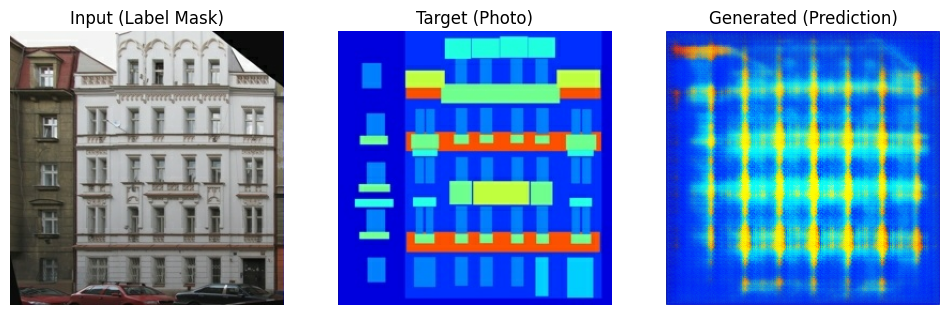


Epoch 2/10
 Step 0: Gen loss = 51.7178, Disc loss = 0.3332
 Step 200: Gen loss = 41.9672, Disc loss = 0.0801


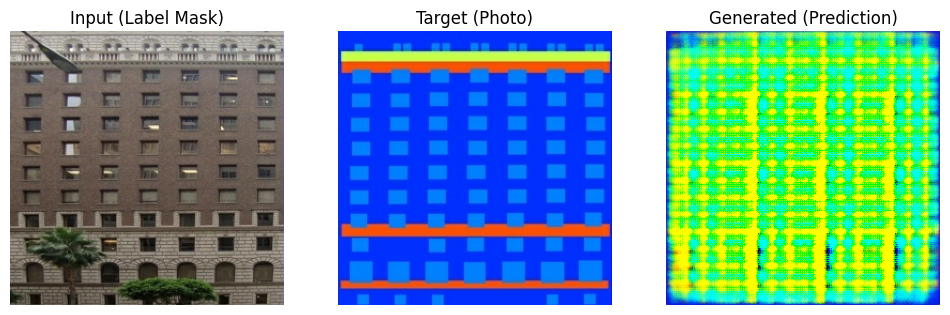


Epoch 3/10
 Step 0: Gen loss = 48.1797, Disc loss = 0.0559
 Step 200: Gen loss = 36.6073, Disc loss = 0.1197


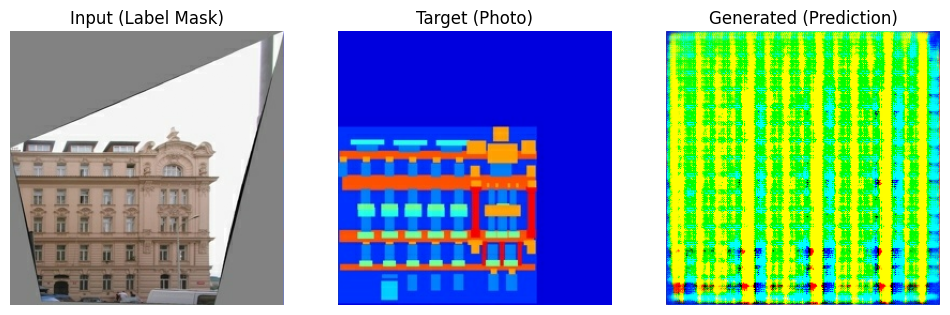


Epoch 4/10
 Step 0: Gen loss = 44.6266, Disc loss = 0.1856
 Step 200: Gen loss = 21.7007, Disc loss = 0.7003


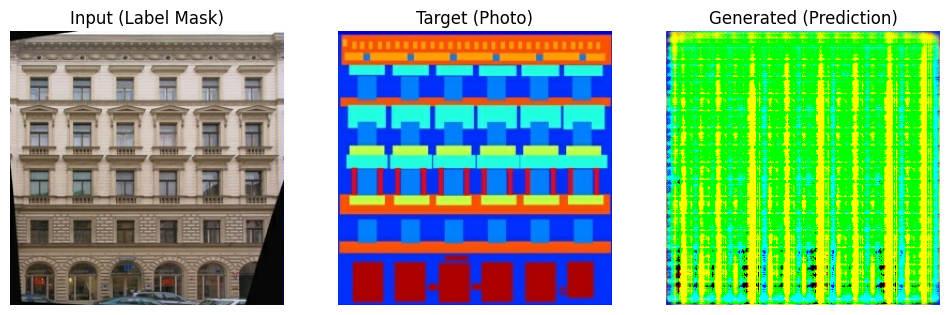


Epoch 5/10
 Step 0: Gen loss = 56.4843, Disc loss = 0.0341
 Step 200: Gen loss = 28.2582, Disc loss = 0.0712


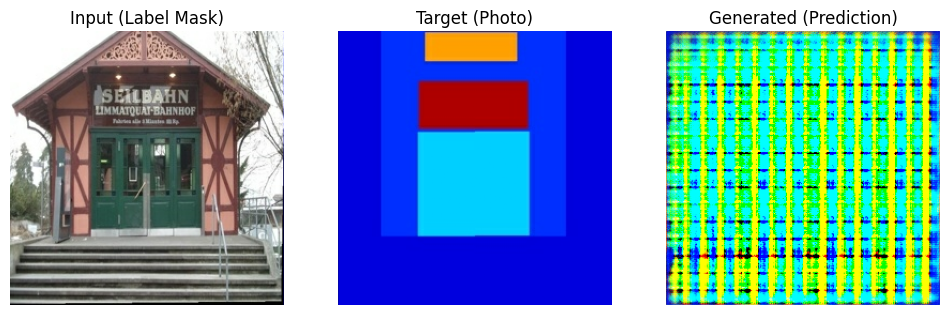


Epoch 6/10
 Step 0: Gen loss = 44.0248, Disc loss = 0.0749
 Step 200: Gen loss = 48.6108, Disc loss = 0.0386


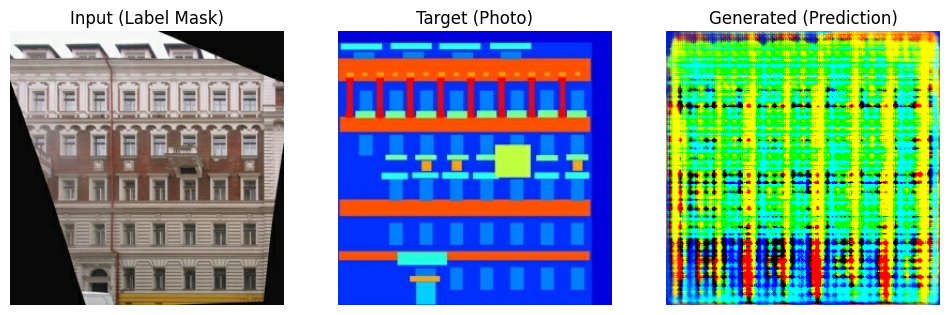


Epoch 7/10
 Step 0: Gen loss = 27.9213, Disc loss = 0.0957
 Step 200: Gen loss = 39.7190, Disc loss = 0.2483


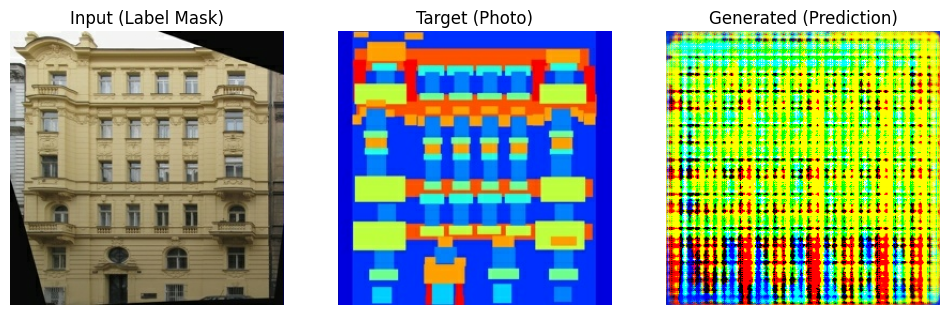


Epoch 8/10
 Step 0: Gen loss = 25.3463, Disc loss = 0.1680
 Step 200: Gen loss = 21.5922, Disc loss = 0.0817


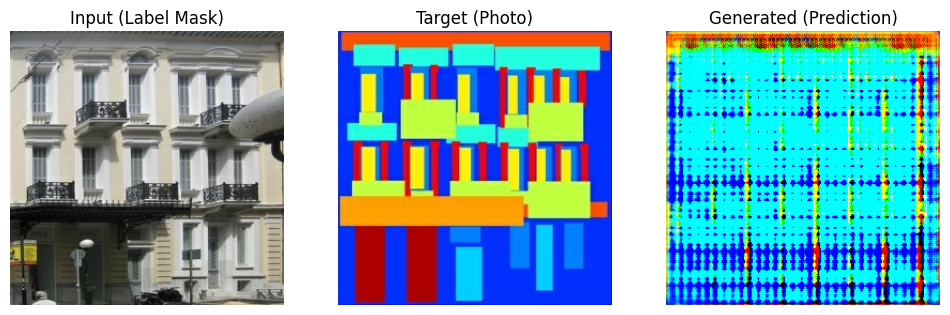


Epoch 9/10
 Step 0: Gen loss = 52.3915, Disc loss = 0.0269
 Step 200: Gen loss = 37.5106, Disc loss = 0.2532


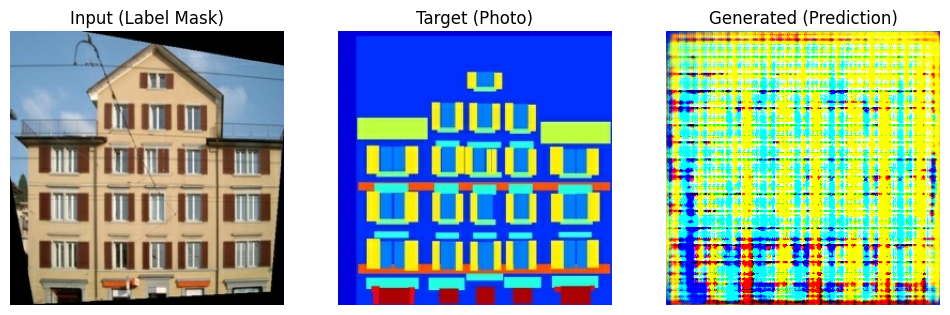


Epoch 10/10
 Step 0: Gen loss = 23.4262, Disc loss = 0.6434
 Step 200: Gen loss = 25.0436, Disc loss = 0.3155


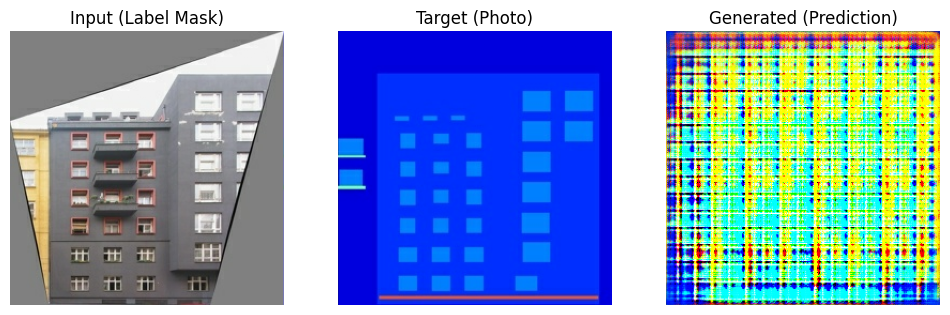

In [51]:
#  9. Training Loop

EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    for step, (inp, tar) in train_dataset.enumerate():
        gen_loss, disc_loss = train_step(inp, tar)
        if int(step) % 200 == 0:
            print(f" Step {int(step)}: Gen loss = {gen_loss:.4f}, Disc loss = {disc_loss:.4f}")

    # show one example from test set
    for inp, tar in test_dataset.take(1):
        pred = generator(inp, training=False)
        display_sample(inp[0], tar[0], pred[0])

In [52]:
#  10. Save Trained Model
generator.save('pix2pix_facades_generator.h5')